In [4]:
# conda activate chronocell

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [5]:
random_seed = 666

In [6]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2) # 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [ ]:
# Simulate data

n = 2000 # No. cells per lineage
p = 500 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 2, 5)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, deg_rate_mu, deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)
P_observed, P = simulate_protein_from_RNA(Y_observed, topo, true_t, true_l, phi, random_seed=random_seed)

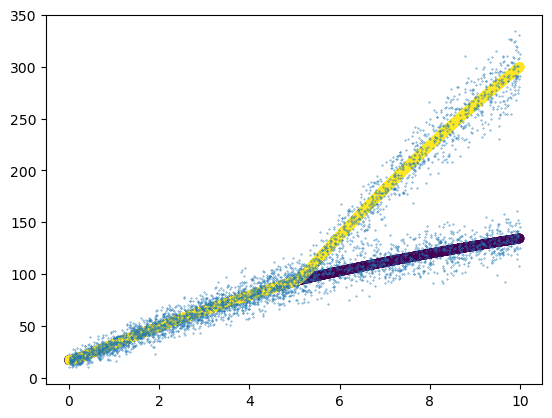

In [15]:
idx = 45
plt.scatter(true_t, Y[:, idx, 1], c=true_l)
plt.scatter(true_t, Y_observed[:, idx, 1], s=.1)

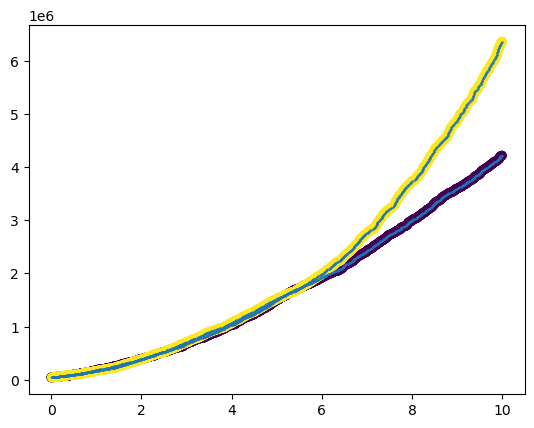

In [16]:
plt.scatter(true_t, P[:, idx], c=true_l)
plt.scatter(true_t, P_observed[:, idx], s=.1)

In [21]:
l = 0
theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)

rows = []
for i in range(p):
    y_i = Y_observed[l*n:(l+1)*n, i, 1]
    p_i = P_observed[l*n:(l+1)*n, i]
    
    row = {
        'Cor': np.corrcoef(y_i, p_i)[0, 1],
        'Starting_y': y_i[0],
        'Alpha': np.mean(theta_l[i, :len(tau)]),
        'Beta': theta_l[i, -2],
        'Gamma': theta_l[i, -1],
        'Translation_rate': phi[i, 0],
        'Degradation_rate': phi[i, -1]
    }
    rows.append(row)
    
data = pd.DataFrame(rows)

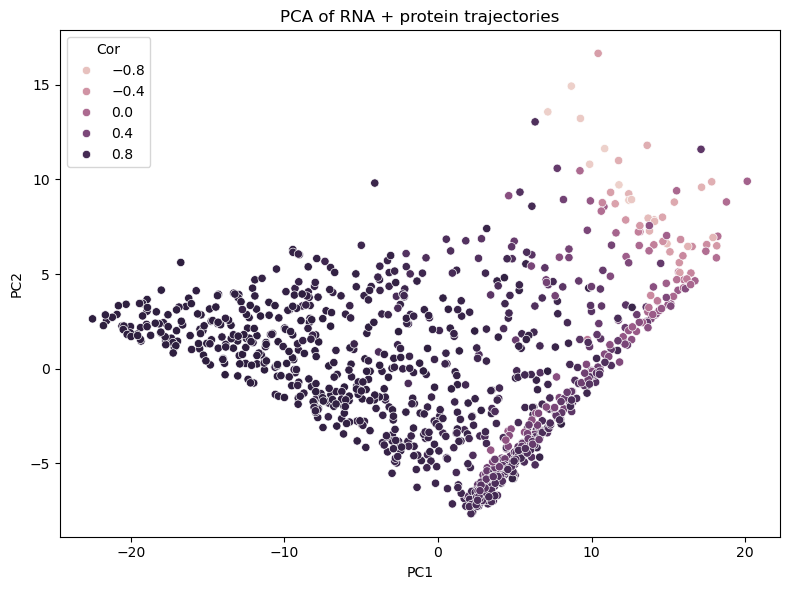

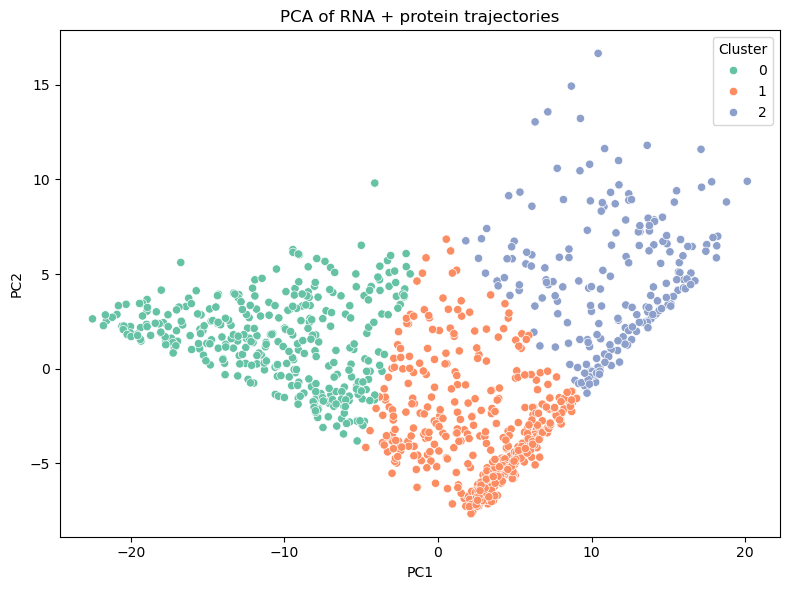

In [22]:
# PCA + Clustering + Visualization Pipeline for RNA/Protein Dynamics

np.random.seed(random_seed)

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

L = len(topo) # number of lineages
n = Y.shape[0] // L
p = Y.shape[1]

Y_traj = np.zeros((p, n))
P_traj = np.zeros((p, n))

for i in range(p):
    Y_traj[i] = Y[l*n:(l+1)*n, i, 1]/np.max(Y[l*n:(l+1)*n, i, 1])  # spliced RNA for gene i in lineage 0
    P_traj[i] = P[l*n:(l+1)*n, i]/np.max(P[l*n:(l+1)*n, i])    # protein for gene i in lineage 0

# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_traj, P_traj], axis=1)
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PCA1'] = traj_pca[:, 0]
data['PCA2'] = traj_pca[:, 1]

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=data, hue='Cluster', palette='Set2')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


         count      mean       std       min       25%       50%       75%  \
Cluster                                                                      
0        344.0  0.950314  0.038783  0.701164  0.939537  0.962576  0.973974   
1        449.0  0.771231  0.147940  0.182083  0.704501  0.801745  0.887629   
2        207.0  0.252692  0.507177 -0.942866 -0.050417  0.378318  0.652709   

              max  
Cluster            
0        0.989640  
1        0.973505  
2        0.937727  
            Alpha      Beta     Gamma  Translation_rate  Degradation_rate
Cluster                                                                  
0        2.562551  8.960376  0.090344        167.269039          0.042878
1        2.567831  8.392543  0.092503        154.139932          0.042993
2        1.525674  5.787752  0.077752        182.688277          0.036606


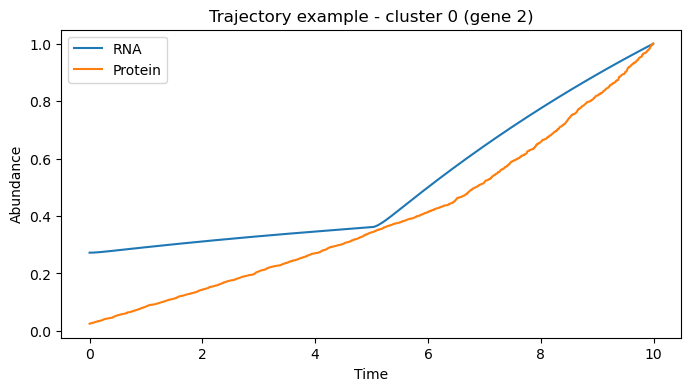

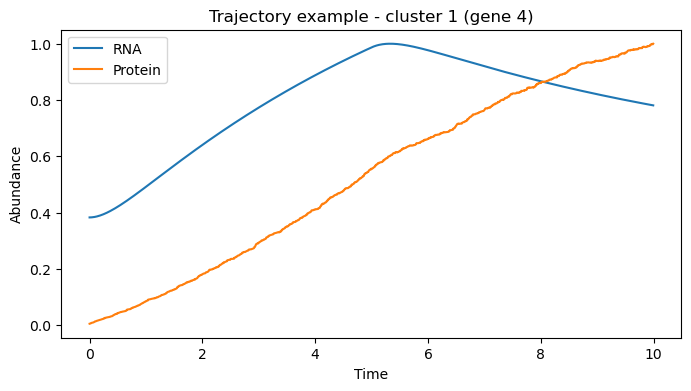

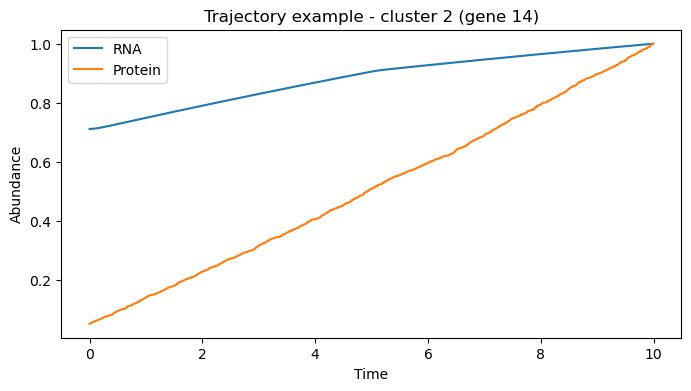

In [24]:
# === Step 5: Correlation Summary by Cluster ===
summary = data.groupby('Cluster')['Cor'].describe()
print(summary)

param_cols = ['Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate']

print(data.groupby('Cluster')[param_cols].mean())

# Plot representative gene trajectories from each cluster
for c in sorted(data['Cluster'].unique()):
    idx = data[data['Cluster'] == c].index[1]  # random gene in cluster
    plt.figure(figsize=(8, 4))
    plt.plot(true_t[true_l == l], Y[l*n:(l+1)*n, idx, 1]/np.max(Y[l*n:(l+1)*n, idx, 1]), label='RNA')
    plt.plot(true_t[true_l == l], P[l*n:(l+1)*n, idx]/np.max(P[l*n:(l+1)*n, idx]), label='Protein')
    plt.title(f'Trajectory example - cluster {c} (gene {idx})')
    plt.xlabel('Time')
    plt.ylabel('Abundance')
    plt.legend()
    plt.show()

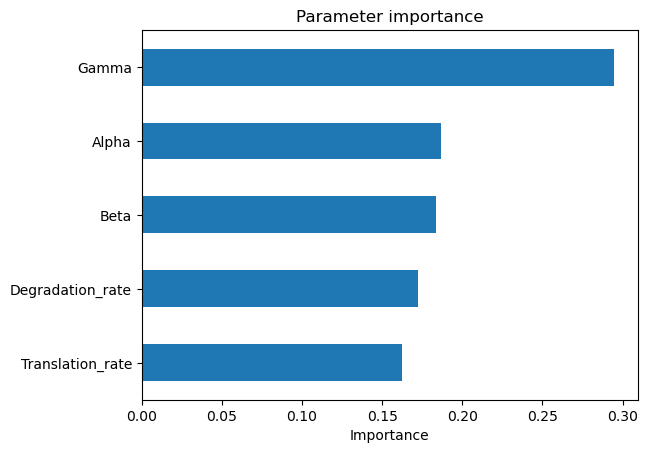

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_params = data[param_cols]
y_clusters = data['Cluster']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_params, y_clusters)

importances = pd.Series(clf.feature_importances_, index=param_cols)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Parameter importance")
plt.xlabel("Importance")
plt.show()

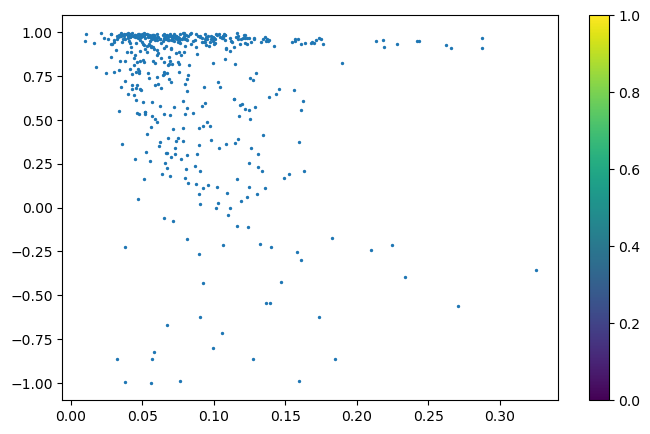

In [ ]:
plt.figure(figsize=(8, 5))
plot = plt.scatter(data_fidataltered['Gamma'], data['Cor'], s=2);
cbar = plt.colorbar(plot);
plt.show();

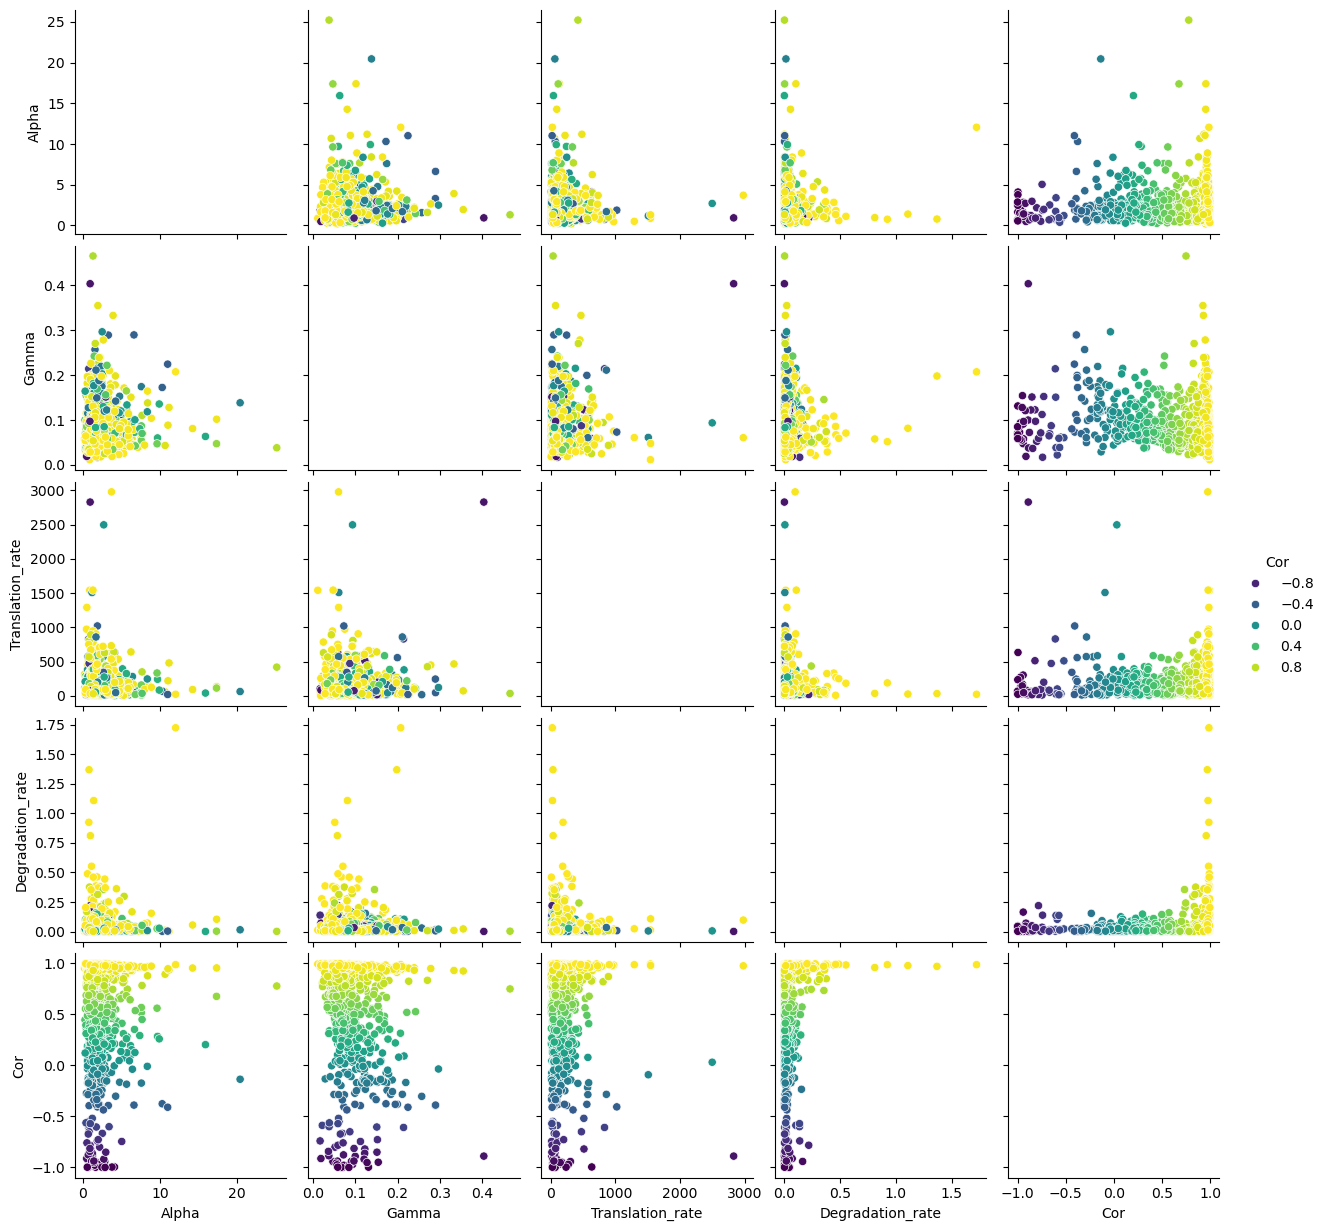

In [88]:
sns.pairplot(data, vars=['Alpha', 'Gamma', 'Translation_rate', 'Degradation_rate', 'Cor'], hue='Cor', palette='viridis')


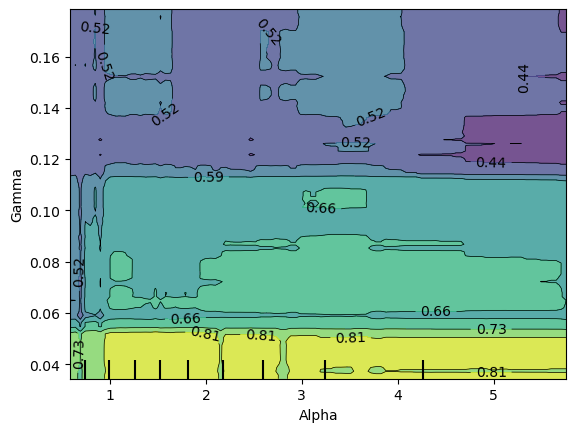

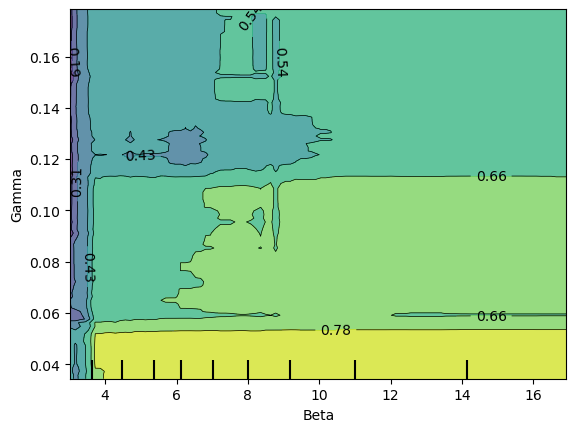

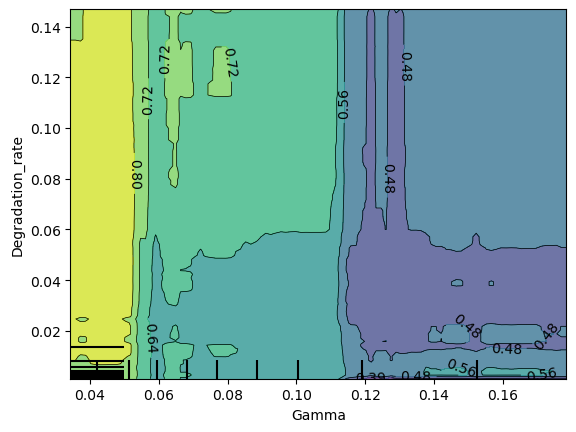

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

X = data[['Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate']]
y = data['Cor']

model = RandomForestRegressor(max_depth=6, random_state=0)
model.fit(X, y)

PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha', 'Gamma')])
plt.show()

PartialDependenceDisplay.from_estimator(model, X, features=[('Beta', 'Gamma')])
plt.show()

PartialDependenceDisplay.from_estimator(model, X, features=[('Gamma', 'Degradation_rate')])
plt.show()


In [103]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Get interaction term names
feature_names = poly.get_feature_names_out(X.columns)
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

Gamma^2                              8.636158
Gamma                               -2.772376
Gamma Degradation_rate               1.354630
Degradation_rate                     0.515630
Alpha Gamma                         -0.379612
Alpha Degradation_rate               0.086746
Alpha                                0.077865
Beta                                 0.067747
Beta Degradation_rate               -0.062930
Beta Gamma                          -0.046200
Degradation_rate^2                  -0.037552
Alpha Beta                          -0.003806
Translation_rate Degradation_rate    0.002699
Alpha^2                             -0.002036
Beta^2                              -0.001687
dtype: float64


In [ ]:

# Range of gamma values
gamma_range = np.linspace(data['Gamma'].min(), data['Gamma'].max(), 200)

# Reconstruct prediction manually (using fitted coefficients)
# This assumes you know the indices or names of your Gamma and Gamma^2 terms
beta_linear = coeffs.get('Gamma', 0)
beta_quad = coeffs.get('Gamma^2', 0)
intercept = model.intercept_

cor_pred = intercept + beta_linear * gamma_range + beta_quad * gamma_range**2

plt.plot(gamma_range, cor_pred)
plt.xlabel('Gamma (RNA degradation rate)')
plt.ylabel('Predicted Correlation')
plt.title('Quadratic Effect of Gamma on RNA–Protein Correlation')
plt.show()


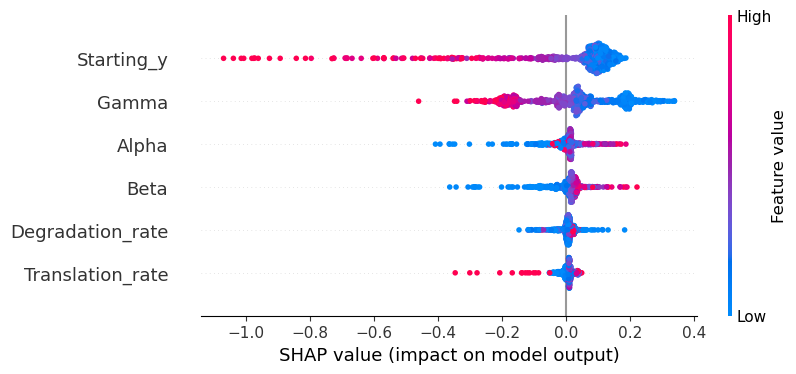

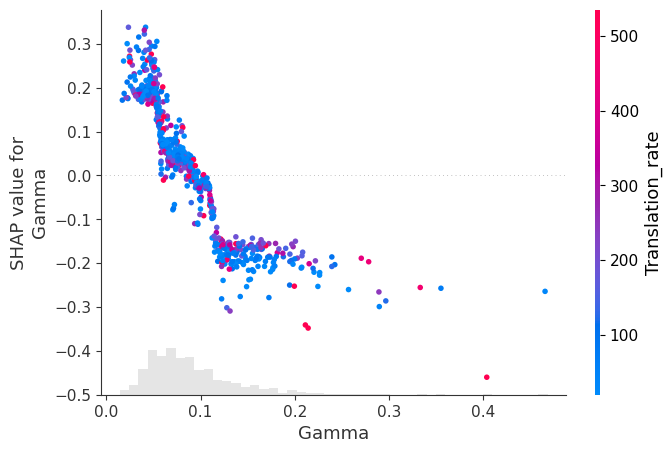

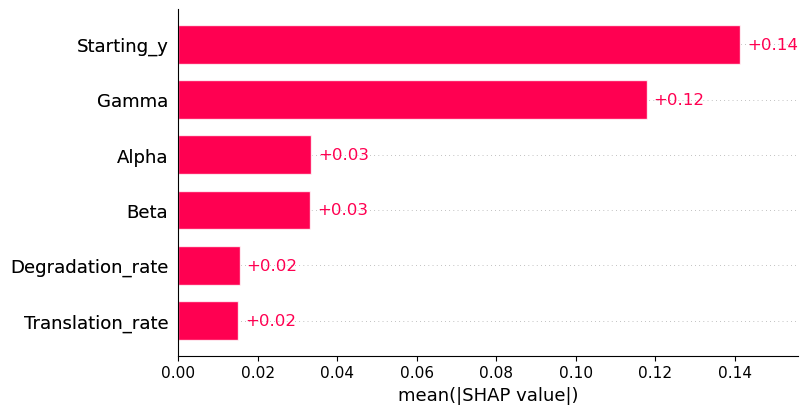

In [111]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Prepare features and target
X = data[['Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate', 'Starting_y']]
y = data['Cor']

# 2. Train/test split (optional but recommended for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Fit Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# 4. Create SHAP explainer with new API
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # Explanation object

# 5. Plot summary (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)

# 6. Plot dependence (e.g. Gamma vs Cor, colored by Translation_rate)
shap.plots.scatter(shap_values[:, "Gamma"], color=shap_values[:, "Translation_rate"])

# 7. If you want bar plot of mean |SHAP| values:
shap.plots.bar(shap_values, max_display=10)
